In [1]:
import numpy as np
import pandas as pd



In [ ]:
!pip install snorkel

In [3]:
import snorkel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [4]:

from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

In [5]:
import nltk
#nltk.download('all')

In [6]:
def stem(word):
  word = word.lower()
  n_word = ""
  for w in word.split():
    n_word +=" "+stemmer.stem(w)
  return n_word


In [7]:
path = '/content/drive/MyDrive/Datasets/Sentences_50Agree.txt'

In [8]:
df = pd.read_csv(path, delimiter='@',encoding='latin-1')
df.head()

,text,sentiment
0,"According to Gran , the company has no plans t...",neutral
1,Technopolis plans to develop in stages an area...,neutral
2,The international electronic industry company ...,negative
3,With the new production plant the company woul...,positive
4,'According to the company ''s updated strategy...,positive


In [9]:
df['text'] = df['text'].map(stem)

In [10]:
#df['text'] = df['text'].map(lemmat)

In [11]:
from sklearn.preprocessing import LabelEncoder
df["sentiment"] = LabelEncoder().fit_transform(df['sentiment'])
df.head()

,text,sentiment
0,"accord to gran , the compani ha no plan to mo...",1
1,technopoli plan to develop in stage an area o...,1
2,the intern electron industri compani elcoteq ...,0
3,with the new product plant the compani would ...,2
4,'accord to the compani '' updat strategi for ...,2


In [12]:
df["sentiment"].value_counts()

# 28.12% data is positive
# 12.46% data is negative
# 59.40% data is neurtal

1    2879
2    1363
0     604
Name: sentiment, dtype: int64

In [46]:
X = df[['text']]
y = df[['sentiment']]

In [47]:
ABSTAIN = 1
NEGATIVE = 0
POSITIVE = 2


    * Polarity: The set of unique labels this LF outputs (excluding abstains)
    * Coverage: The fraction of the dataset the LF labels
    * Overlaps: The fraction of the dataset where this LF and at least one other LF label
    * Conflicts: The fraction of the dataset where this LF and at least one other LF label and disagree
    * Correct: The number of data points this LF labels correctly (if gold labels are provided)
    * Incorrect: The number of data points this LF labels incorrectly (if gold labels are provided)
    * Empirical Accuracy: The empirical accuracy of this LF (if gold labels are provided)


In [71]:
ABSTAIN = 1
NEGATIVE = 0
POSITIVE = 2

In [72]:
from snorkel.labeling import labeling_function

@labeling_function()
def check_increase(x):
  output = ABSTAIN
  if "increas" in str(x.text): output = POSITIVE
  if "won" in str(x.text): output = POSITIVE
  if "rais" in str(x.text): output = POSITIVE
  if "good" in str(x.text): output = POSITIVE
  if "doubl" in str(x.text): output = POSITIVE
  if "profit" in str(x.text): output = POSITIVE
  if "improv" in str(x.text): output = POSITIVE
  if "grown" in str(x.text): output = POSITIVE
  if "promot" in str(x.text): output = POSITIVE
  if "build" in str(x.text): output = POSITIVE
  if "up" in str(x.text): output = POSITIVE
  if "boost" in str(x.text): output = POSITIVE
  if "applaud" in str(x.text): output = POSITIVE
  return output


@labeling_function()
def check_decrease(x):
  output = ABSTAIN

  if "decreas" in str(x.text): output = NEGATIVE
  if "bad" in str(x.text): output = NEGATIVE
  if "declin" in str(x.text): output = NEGATIVE
  if "loss" in str(x.text): output = NEGATIVE
  if "halv" in str(x.text): output = NEGATIVE
  if "laid" in str(x.text): output = NEGATIVE
  if "down" in str(x.text): output = NEGATIVE
  if "weaken" in str(x.text): output = NEGATIVE
  if "weak" in str(x.text): output = NEGATIVE
  if "low" in str(x.text): output = NEGATIVE

  return output
  
#Just assuming that the words after but are mostly positive, will imporve later
@labeling_function()
def check_but(x):
  output = ABSTAIN

  if "but" in str(x.text): output = POSITIVE
  if "however" in str(x.text): output = POSITIVE

  return output







In [73]:
from snorkel.labeling import PandasLFApplier

lfs = [check_increase,check_decrease,check_but]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=X)


100%|██████████| 4846/4846 [00:01<00:00, 4603.94it/s]


In [74]:
#Check out the coverage
coverage_check_increase, coverage_check_decrease,coverage_check_but = (L_train != ABSTAIN).mean(axis=0)
print(f"check_out increase: {coverage_check_increase * 100:.1f}%")
print(f"check_out decrease: {coverage_check_decrease * 100:.1f}%")
print(f"check_out but: {coverage_check_but * 100:.1f}%")

check_out increase: 31.2%
check_out decrease: 11.6%
check_out but: 1.9%


In [75]:
from snorkel.labeling import LFAnalysis
LFAnalysis(L=L_train, lfs=lfs).lf_summary()


,j,Polarity,Coverage,Overlaps,Conflicts
check_increase,0,"[1, 2]",1.0,1.0,0.393314
check_decrease,1,"[0, 1]",1.0,1.0,0.393314
check_but,2,"[1, 2]",1.0,1.0,0.393314


In [76]:
# Combining label outputs with label model
L_train.shape[0]
majority  =[]
for arr in L_train:
  if arr[2]==2:
    majority.append(2)
  else:
    if arr[0]==2:
      majority.append(2)
    elif arr[1]==1:
      majority.append(1)
    else:
      majority.append(0)


In [81]:
from sklearn.metrics import accuracy_score
print("Accuracy Score with simple mode {:.2f}%".format(100*accuracy_score(majority, y)))

Accuracy Score with simple mode 61.02%


In [85]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(majority,y)
print(cf_matrix)

[[ 154  112   58]
 [ 208 2115  617]
 [ 242  652  688]]


[Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Neutral'), Text(0, 2.5, 'Positive')]

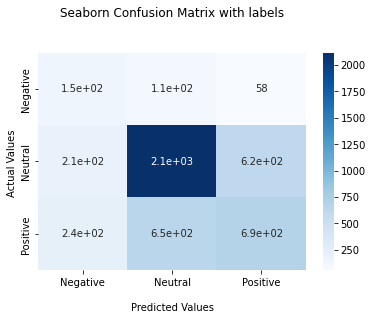

In [91]:
import seaborn as sns
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negative','Neutral','Positive'])
ax.yaxis.set_ticklabels(['Negative','Neutral','Positive'])
